In [244]:
import gizeh
import numpy as np

In [334]:
def get_neighbour_influence(angle, influence):
    """Get a coefficient of influence in neighbour cell
    
    Parameters
    ----------
    angle : float
        Angle between flow direction and the given neighbour
        
    influence : float
        
    Returns
    -------
    influence : float
        Number representing influence of a stem cell in the neighbour cell. In this model we assume that it changes
        linearly with the change of the angle. It equals 0 in the opposite direction from the flow 
        and flow/2 in the direction of the flow
    """
    angle = angle % (2*np.pi)
    return influence * abs(np.pi - angle) / (2*np.pi)

In [350]:
class Cell:
    MAX_CONCENTRATION = 1024
    
    def __init__(self, x, y, radius, is_stem=False, stem_angle=None):
        self.x = x
        self.y = y
        self.radius = radius
        self.is_stem = is_stem
        self.neighbours = {}
        self.checked = False
        self.gradient = {x:None,
                         y:None}
        
        self.stem_angle = stem_angle if self.is_stem else None
        self.concentration = Cell.MAX_CONCENTRATION if self.is_stem else None
            
    def __repr__(self):
        return '(x: {x}, y: {y}), {c} {stem}, gradient: ({g_x}, {g_y})'.format(
                 x = self.x,
                 y = self.y,
                 c = self.concentration,
                 stem = '*' if self.is_stem else '',
                 g_x = round(self.gradient['x'], 2),
                 g_y = round(self.gradient['y'], 2))

    def set_gradient(self):
        self.checked = True
        
        self.concentration = Cell.MAX_CONCENTRATION
        gradient_angle = self.stem_angle + np.pi

        self.gradient['x'] = self.concentration * np.cos(gradient_angle)
        self.gradient['y'] = self.concentration * np.sin(gradient_angle)

        for neighbour, angle in self.neighbours.items():
            influence = get_neighbour_influence(gradient_angle - angle, self.concentration)
            neighbour.run_flow(gradient_angle, influence)
            
    def run_flow(self, flow_direction, influence):
        self.checked = True
        
        self.concentration += influence
        self.gradient['x'] += influence * np.cos(flow_direction)
        self.gradient['y'] += influence * np.sin(flow_direction)
        
        for neighbour, angle in self.neighbours.items():
            if not (neighbour.checked or neighbour.is_stem):  # Let's not go through stem cells too
                neighbour_influence = get_neighbour_influence(flow_direction - angle, influence)                
                neighbour.run_flow(flow_direction, neighbour_influence)
        
        
    def add_neighbour(self, angle, neighbour):
        self.neighbours[neighbour] = angle
        neighbour.neighbours[self] = (np.pi + angle) % (2*np.pi)
        
    def gradient_angle(self):
        return np.arctan2(self.gradient['y'], self.gradient['x'])
        
    def divide(self):
        """Return a new neighbour of the cell in the direction of the gradient"""
        return Cell(None, None, self.radius), self.gradient_angle() # x and y don't matter now

In [381]:
class Organism:
    
    DIVIDING_CONCENTRATION = 500
    STEM_CONCENTRATION = 150
    
    def __init__(self, x=0, y=0, radius=30, stem_angle=-np.pi/2):
        self.cells = [Cell(x=x, y=y, radius=radius, is_stem=True, stem_angle=stem_angle)]
        self.root_cell = self.cells[0]
        
        self.log = []
        self.log.append('Created cell with x={x}, y={y}, radius={r}, stem_angle={ang}\n'.format(x=x,
                                                                                                y=y,
                                                                                                r=radius,
                                                                                                ang=stem_angle))
        
    def print_log(self):
        return ''.join(self.log)
        
    def reset_checks(self):
        """Set `cell.checked` attribute of each cell to False"""
        for cell in self.cells:
            cell.checked = False
            
        self.log.append('Reset checks\n')
        
    def set_gradients(self):
        """Set all the gradients and concentrations for `self.cells`"""        
        self.log.append('Setting gradients\n')
        
        stem_cells = []
        
        self.log.append('Gradients and concentration set to 0\n')
        
        for cell in self.cells:
            cell.concentration = 0
            cell.gradient = {'x': 0,
                             'y': 0}
            if cell.is_stem:
                stem_cells.append(cell)
        
        for cell in stem_cells:
            self.reset_checks()
            self.log.append('Setting the gradient for stem cell {}\n'.format(cell))
            self.log.append('Cells before cetting the gradient:\n {}\n'.format('\n---'.join(map(str, self.cells))))
            cell.set_gradient()
            
        
        
    
    def draw(self, size=500):
        """Draw the organism"""        
        surface = gizeh.Surface(width=size, height=size)
        
        offset = size/2
        
        for cell in self.cells:
            circle = gizeh.circle(r=cell.radius,
                                  xy=[cell.x + offset, cell.y + offset],
                                  fill=(cell.concentration/Cell.MAX_CONCENTRATION, 0, 0),
                                  stroke=(0,0,0),
                                  stroke_width=2)
            circle.draw(surface)
            
            # draw the gradient of the cell as an arrow
            triangle = gizeh.regular_polygon(r=cell.radius/5, n=3, angle=0,
                                             xy=[cell.x+offset+.5*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                                 cell.y+offset], fill=(1,1,1))
            
            line = gizeh.polyline(points=[(cell.x+offset, cell.y+offset),
                                          (cell.x+offset+.5*cell.radius*cell.concentration/Cell.MAX_CONCENTRATION,
                                           cell.y+offset)],
                                           stroke_width=3, stroke=(1,1,1))
            
            arrow = gizeh.Group([triangle, line])
            arrow = arrow.rotate(cell.gradient_angle(), center=[cell.x+offset,cell.y+offset])
            arrow.draw(surface)
            
            if cell.is_stem:
                stem_r = cell.radius / 5
                
                circle = gizeh.circle(r=stem_r,
                                      xy=[
                                          cell.x + offset + (cell.radius - stem_r)*np.cos(cell.stem_angle),
                                          cell.y + offset + (cell.radius - stem_r)*np.sin(cell.stem_angle),
                                      ],
                                      fill=(0,0,1))
                circle.draw(surface)
                
            
        return surface
    
    def divide_cells(self, cells_to_divide=None):
        
        cells_to_divide = cells_to_divide if cells_to_divide is not None else self.cells
        self.log.append('Going to divide {} cells\n'.format(len(cells_to_divide)))
        
        new_cells = []
        
        for cell in cells_to_divide:
            new_cell, angle = cell.divide()
            self.insert_cell(new_cell, cell, angle)
            new_cells.append(new_cell)
            cell.checked = False  # Reset all checks for checking correctness later
            
        self._check_correctness(self.root_cell)
        
        self.log.append('Trying to add {} new cells\n'.format(len(new_cells)))
        
        for new_cell in new_cells:
            if self.has_intersection(new_cell):
                self.delete_cell(new_cell)
            else:
                self.cells.append(new_cell)
        
        self.set_gradients()
        
    def has_intersection(self, cell):
        """Return True if cell has an intersection with any of `self.cells`"""
        
        for self_cell in self.cells:
            lower = abs(cell.radius-self_cell.radius)
            # Better to round for avoiding false positives
            centers_dist = round(((cell.x-self_cell.x)**2 + (cell.y-self_cell.y)**2)**(.5), 6) 
            upper = cell.radius + self_cell.radius
            
            # Circles intersect iff lower <= centers_dist <= upper
            if lower <= centers_dist < upper:
                self.log.append('Cell {} intersected with {}\n'.format(cell, self_cell))
                self.log.append('Lower bound: {}\n'.format(lower))
                self.log.append('Distance between centers: {}\n'.format(centers_dist))
                self.log.append('Upper bound: {}\n'.format(upper))
                return True
                
        return False
        
    def delete_cell(self, cell):
        """Delete a cell from the organism. Don't apply to cells in a center, it won't work well!"""        
        self.log.append('Deleting cell {}\n'.format(cell))
        
        neighbours_to_delete = [neighbour for neighbour in cell.neighbours]
        
        for neighbour in neighbours_to_delete:
            del cell.neighbours[neighbour]
        
        if cell in self.cells:
            self.cells.remove(cell)
        
        
    def _check_correctness(self, cell):
        """Set correct coordinates to all the cells"""
        cell.checked = True
        
        for neighbour, angle in cell.neighbours.items():
            if not neighbour.checked:
                neighbour.x = cell.x + 2*cell.radius*np.cos(angle)
                neighbour.y = cell.y + 2*cell.radius*np.sin(angle)
                self._check_correctness(neighbour)
                
                
    def insert_cell(self, cell, old_cell, angle):
        """Insert the `cell` between `old_cell` and all other cells.
         
        old_cell, angle=0
          |
          v
        O\ /O     O\   /O
        O-O-O --> O-O-O-O   
        O/ \O     O/   \O
        
        Neighbours of the `old_cell` from `angle`-numpy.pi/2 to `angle`+numpy/pi/2 will become the neighbours
        of the `cell`.
        """
        neighbours_to_delete = []
        
        for neighbour, neighbour_angle in old_cell.neighbours.items():
            if (angle - np.pi/2) < neighbour_angle <= (angle + np.pi/2):
                neighbours_to_delete.append(neighbour)
                cell.add_neighbour(neighbour_angle, neighbour)
                
        old_cell.add_neighbour(angle, cell)
                
        for neighbour in neighbours_to_delete:
            del old_cell.neighbours[neighbour]
            
    def iterate(self):
        
        self.log.append('Making a new iterarion\n')
        
        self.set_gradients()
        cells_to_divide = [cell for cell in self.cells if cell.concentration >= Organism.DIVIDING_CONCENTRATION]
        
        self.divide_cells(cells_to_divide)       
        
        new_stems = [cell for cell in self.cells if cell.concentration < Organism.STEM_CONCENTRATION]
        
        for cell in new_stems:
            cell.is_stem = True
            cell.stem_angle = cell.gradient_angle() + np.pi/2
        
        self.set_gradients()       
        
        self.log.append('Iterated, cells now:\n {}\n\n'.format('\n---'.join(map(str, self.cells))))

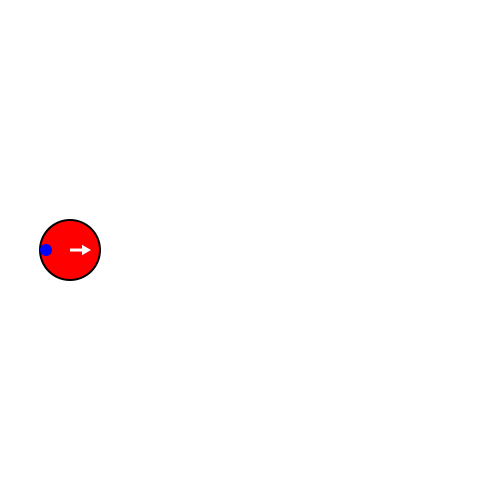

In [382]:
wormy = Organism(x=-180, y=0, radius=30, stem_angle=np.pi)
wormy.set_gradients()
wormy.draw()

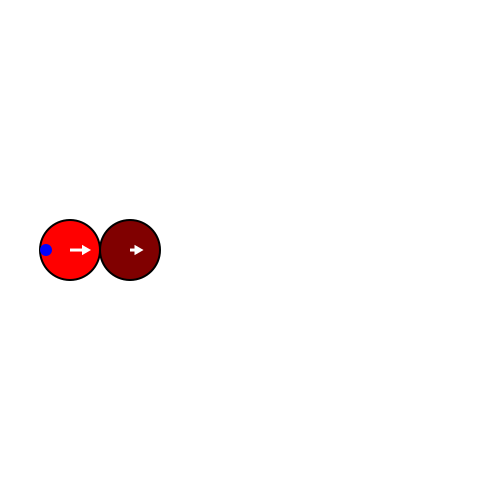

In [384]:
wormy.iterate()
wormy.draw()

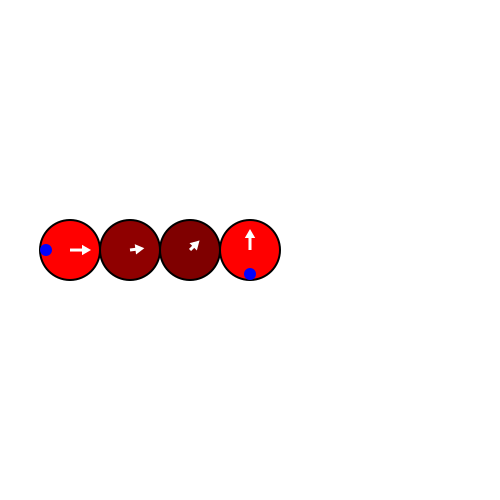

In [385]:
wormy.iterate()
wormy.draw()

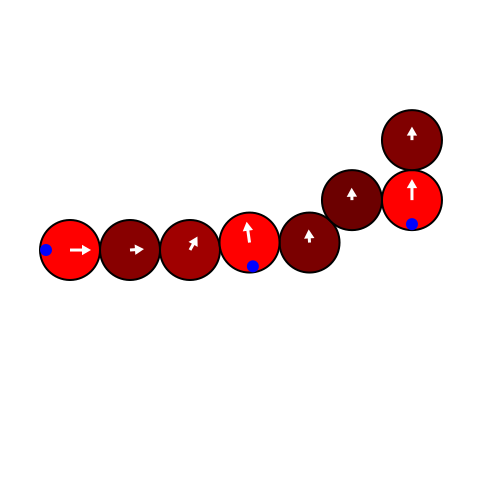

In [386]:
wormy.iterate()
wormy.draw()

In [387]:
for cell in wormy.cells:
    print(cell)
    for neighbour in cell.neighbours:
        print('---', neighbour)

(x: -180, y: 0), 1024 *, gradient: (1024.0, -0.0)
--- (x: -120.0, y: -1.469576158976824e-14), 545.2838849995212 , gradient: (509.6, -33.12)
(x: 59.536672602820055, y: -7.442084075352562), 489.2580716961787 , gradient: (-32.44, -486.99)
--- (x: -180, y: 0), 1024 *, gradient: (1024.0, -0.0)
--- (x: -60.0, y: -2.939152317953648e-14), 641.970141595549 , gradient: (211.22, -382.84)
--- (x: 101.9630794740129, y: -49.868490946545414), 434.2913683481743 , gradient: (-11.45, -433.49)
--- (x: -0.4633273971799454, y: -7.442084075352547), 1024 *, gradient: (-142.43, -1014.05)
(x: -60.0, y: -2.939152317953648e-14), 641.970141595549 , gradient: (211.22, -382.84)
--- (x: -180, y: 0), 1024 *, gradient: (1024.0, -0.0)
--- (x: -120.0, y: -1.469576158976824e-14), 545.2838849995212 , gradient: (509.6, -33.12)
--- (x: -0.4633273971799454, y: -7.442084075352547), 1024 *, gradient: (-142.43, -1014.05)
(x: 161.9630794740129, y: -49.86849094654543), 1024 *, gradient: (-0.0, -1024.0)
--- (x: 59.536672602820055,

In [388]:
wormy.cells

[(x: -180, y: 0), 1024 *, gradient: (1024.0, -0.0),
 (x: 59.536672602820055, y: -7.442084075352562), 489.2580716961787 , gradient: (-32.44, -486.99),
 (x: -60.0, y: -2.939152317953648e-14), 641.970141595549 , gradient: (211.22, -382.84),
 (x: 161.9630794740129, y: -49.86849094654543), 1024 *, gradient: (-0.0, -1024.0),
 (x: -120.0, y: -1.469576158976824e-14), 545.2838849995212 , gradient: (509.6, -33.12),
 (x: 101.9630794740129, y: -49.868490946545414), 434.2913683481743 , gradient: (-11.45, -433.49),
 (x: -0.4633273971799454, y: -7.442084075352547), 1024 *, gradient: (-142.43, -1014.05),
 (x: 161.9630794740129, y: -109.86849094654542), 512.0 , gradient: (-0.0, -512.0)]

In [389]:
print(wormy.print_log())

Created cell with x=-180, y=0, radius=30, stem_angle=3.141592653589793
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
Making a new iterarion
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
Going to divide 1 cells
Trying to add 1 new cells
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
---(x: -120.0, y: -1.469576158976824e-14), 0 , gradient: (0, 0)
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)

In [390]:
wormy.iterate()
wormy.draw()

KeyError: 'x'

In [391]:
print(wormy.print_log())

Created cell with x=-180, y=0, radius=30, stem_angle=3.141592653589793
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
Making a new iterarion
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
Going to divide 1 cells
Trying to add 1 new cells
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)
Cells before cetting the gradient:
 (x: -180, y: 0), 0 *, gradient: (0, 0)
---(x: -120.0, y: -1.469576158976824e-14), 0 , gradient: (0, 0)
Setting gradients
Gradients and concentration set to 0
Reset checks
Setting the gradient for stem cell (x: -180, y: 0), 0 *, gradient: (0, 0)